In [84]:
import numpy as np
import pandas as pd
import pickle
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
import seaborn as sns

# 1: Loading data

In [85]:
file_Name = 'output/US_weather_7yr_avg'

# Open the file for reading
file_object = open(file_Name,'rb')
# load the object from the file into var b
concat_df = pickle.load(file_object)

concat_df.head(5)

lat       lon     skyc1     skyc2     skyc3  skyc4  \
valid station                                                           
01/01 ABQ      35.0419 -106.6155  2.568293  5.023207  7.064626    6.0   
      ATL      33.6301  -84.4418  4.205607  6.340000  6.888889    8.0   
      BDL      41.9381  -72.6825  1.939539  5.680851  5.347826    NaN   
      BHM      33.5655  -86.7449  2.685668  6.625616  7.802469    6.0   
      BNA      36.1189  -86.6892  3.841338  6.008696  6.840426    6.0   

                     skyl1        skyl2        skyl3    skyl4  avg_cloud  
valid station                                                             
01/01 ABQ      6443.572266  5275.472656  5916.993164  14000.0   3.319888  
      ATL      3889.860596  6125.756348  8683.901367  13750.0   5.120699  
      BDL      8713.620117  8003.191406  7108.695801      NaN   2.130277  
      BHM      7050.569824  6021.083984  6507.357910  14000.0   3.247213  
      BNA      6071.336426  5639.886719  5055.212891  20000.0   3.858672

In [86]:
dates = []
for date, new_df in concat_df.groupby(level=0):
    dates.append(date)

# 2: Training interpolation model

In [34]:
idx = pd.IndexSlice
kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
gprs = {}

for date in dates:
    lats = concat_df.loc[idx[date, :],'lat'].tolist()
    lons = concat_df.loc[idx[date, :],'lon'].tolist()
    points = np.column_stack((lats, lons))
    values = concat_df.loc[idx[date, :],'avg_cloud'].tolist()
    gpr = GaussianProcessRegressor(kernel=kernel, random_state=0, n_restarts_optimizer=9, normalize_y=True)
    gpr.fit(points, values)
    
    gprs[date] = gpr

In [37]:
gpr_model = gprs

### 2.1 Loading and Unloading gprs pickle

In [6]:
file_name = 'output/gprs_7yr_pickled'
# Open the file for writing
with open(file_name,'wb') as handle:
    pickle.dump(gprs, handle, protocol=pickle.HIGHEST_PROTOCOL)  

In [87]:
file_Name = 'output/gprs_7yr_pickled'
# file_Name = 'gprs_5yr_pickled'

# Open the file for reading
with open(file_Name,'rb') as handle:
# load the object from the file into var b
    gpr_model = pickle.load(handle)

# 3: Generating Results

#### Model returns average Cloud Cover Okta value for any location and day of the year

In [88]:
date = '01/01'
test_location = ([36.12],[-86.7])

# testing out model
gpr_model[date].predict(np.column_stack(test_location))

array([3.85860983])

# 4: Bonus Content: Code for producing a Heatmap for a nice Visualisation

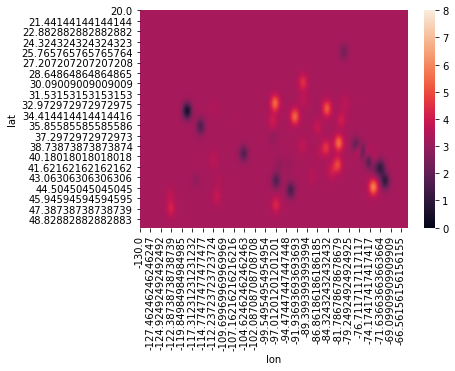

In [9]:
# Latitude from 19.50139 to 64.85694 and longitude from -161.75583 to -68.01197. This is including Alaska

# from a map it seems that a more realistic range is x/lon (-130,-65) and lat/y (20,50)
xmin, xmax, ymin, ymax = -130, -65, 20, 50

x1 = np.linspace(xmin,xmax,1000)
x2 = np.linspace(ymin,ymax,1000)
lons, lats = np.meshgrid(x1, x2)

y_pred= gpr_model['01/01'].predict(np.column_stack((lats.flatten(),lons.flatten())))

# How it was trained
# points = np.column_stack((lats, lons))
# gpr.fit(points, values)

data = np.column_stack((lons.flatten(),lats.flatten(),y_pred.flatten()))
columns = ['lon','lat','avg_cloud']
df = pd.DataFrame(data=data, columns=columns)

df_pivot = df.pivot("lat","lon","avg_cloud")
ax = sns.heatmap(df_pivot, vmin=0, vmax=8)

In [77]:
import branca
import branca.colormap as cm
colormap = cm.LinearColormap(colors=['darkblue', 'blue', 'cyan', 'yellow', 'orange', 'red'],
                             vmin=0, vmax=8,
                             caption='Color Map')

In [78]:
import geopandas as gpd
import folium
import os
from folium.plugins import HeatMap

In [81]:
m = folium.Map(location=[37, -95.5], zoom_start=5)

hm_wide = HeatMap(list(zip(df.lat.values, df.lon.values, df.avg_cloud.values)),
                  min_opacity=0,
                  radius=17, blur=15,
                  max_zoom=12,
                  name="Cloud Cover Heatmap"
                 )

m.add_child(colormap)

hm_wide.add_to(m)
folium.LayerControl().add_to(m)

m.save(os.path.join('output', 'heatmap.html'))

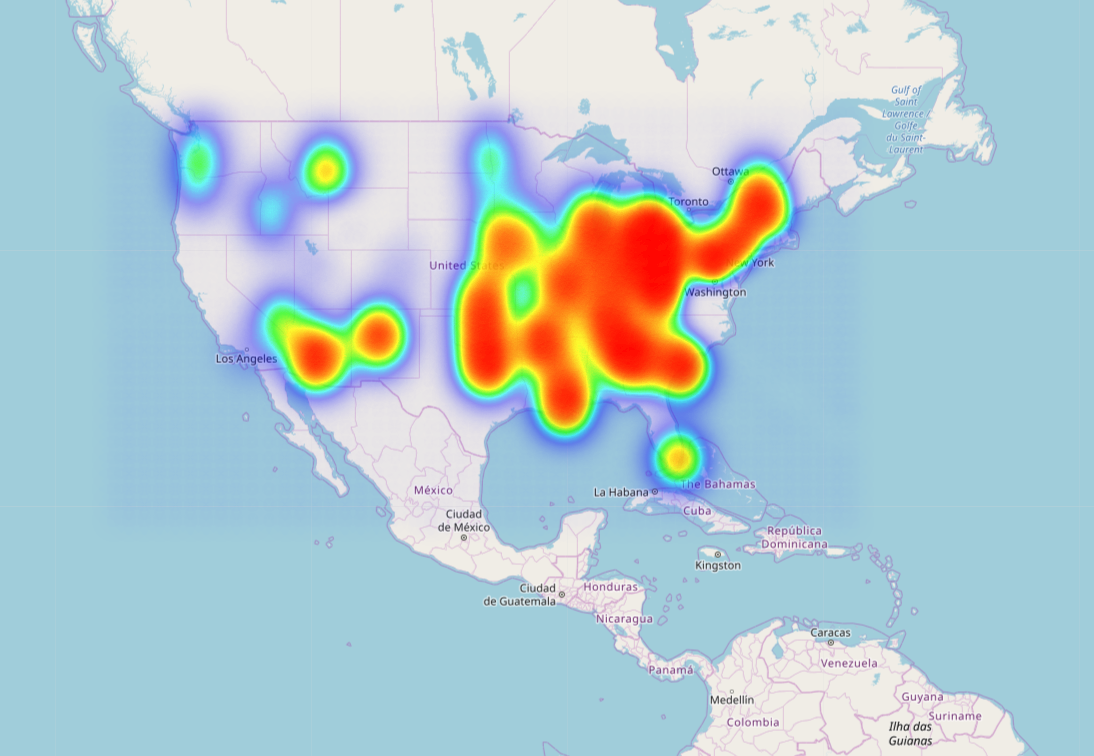

### 4.1 Nearest Neighbours Interpolation (not needed)

In [157]:
from sklearn.neighbors import KNeighborsRegressor

dates = []
for date, new_df in concat_df.groupby(level=0):
    dates.append(date)

idx = pd.IndexSlice
kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
nbrs = {}

for date in dates:
    lats = concat_df.loc[idx[date, :],'lat'].tolist()
    lons = concat_df.loc[idx[date, :],'lon'].tolist()
    points = np.column_stack((lats, lons))
    values = concat_df.loc[idx[date, :],'avg_cloud'].tolist()
    
#     gpr = GaussianProcessRegressor(kernel=kernel, random_state=0, n_restarts_optimizer=9, normalize_y=True)
#     gpr.fit(points, values)
#     gprs[date] = gpr
    
    neigh = KNeighborsRegressor(n_neighbors=3)
    neigh.fit(points, values)
    nbrs[date] = neigh

In [158]:
# testing out model
nbrs['01/01'].predict(np.column_stack(([36.12],[-86.7])))

array([3.97119875])

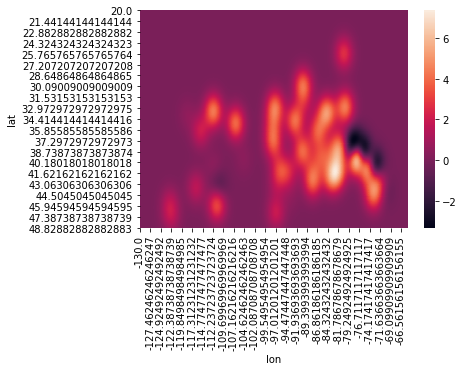

In [36]:
# Latitude from 19.50139 to 64.85694 and longitude from -161.75583 to -68.01197. This is including Alaska

# from a map it seems that a more realistic range is x/lon (-130,-65) and lat/y (20,50)
xmin, xmax, ymin, ymax = -130, -65, 20, 50

x1 = np.linspace(xmin,xmax,1000)
x2 = np.linspace(ymin,ymax,1000)
lons, lats = np.meshgrid(x1, x2)

y_pred= gpree['01/01'].predict(np.column_stack((lats.flatten(),lons.flatten())))

# How it was trained
# points = np.column_stack((lats, lons))
# gpr.fit(points, values)

data = np.column_stack((lons.flatten(),lats.flatten(),y_pred.flatten()))
columns = ['lon','lat','avg_cloud']
df = pd.DataFrame(data=data, columns=columns)

df_pivot = df.pivot("lat","lon","avg_cloud")
ax = sns.heatmap(df_pivot)

In [161]:
df.describe()

,lon,lat,avg_cloud
count,1000000.000000,1000000.000000,1.000000e+06
mean,-97.500000,35.000000,6.577898e-01
std,18.782666,8.668923,1.227426e+00
min,-130.000000,20.000000,-3.310085e+00
25%,-113.750000,27.500000,9.746065e-08
50%,-97.500000,35.000000,3.004317e-02
75%,-81.250000,42.500000,8.344677e-01
max,-65.000000,50.000000,7.348422e+00


### 4.2 Making heatmap movie/ GIF using Selenium to automatically capture screenshots

In [35]:
import os
import time
from selenium import webdriver

max_amount = 8
xmin, xmax, ymin, ymax = -130, -65, 20, 50
x1 = np.linspace(xmin,xmax,1000)
x2 = np.linspace(ymin,ymax,1000)
lons, lats = np.meshgrid(x1, x2)

for date in dates:
    # Getting data
    y_pred = gpree[date].predict(np.column_stack((lats.flatten(),lons.flatten())))
    data = np.column_stack((lons.flatten(),lats.flatten(),y_pred.flatten()))
    columns = ['lon','lat','avg_cloud']
    df = pd.DataFrame(data=data, columns=columns)

    # Outputting and saving map on Selenium
    delay=5

    file_name = f"{date}"
    file_name = file_name.replace("/","_")
    fn=f"{file_name}.html"
    tmpurl='file://{path}/output_htmls/{mapfile}'.format(path=os.getcwd(),mapfile=fn)

    hmap = folium.Map(location=[40, -85.5], zoom_start=4)
    hm_wide = HeatMap( list(zip(df.lat.values, df.lon.values, df.avg_cloud.values)),
                       min_opacity=0.001,
                       max_val=max_amount,
                       radius=17, blur=15, 
                       max_zoom=13)
    
    hmap.add_child(hm_wide)
    hmap.save(os.path.join('output_htmls', fn))
    
    options = webdriver.ChromeOptions()
    options.binary_location = "/Google Chrome.app/Contents/MacOS/Google Chrome"
    chrome_driver_binary = "/Users/zarif.aziz/Downloads/chromedriver"
    browser = webdriver.Chrome(chrome_driver_binary, chrome_options=options)

    #browser = webdriver.Chrome(executable_path="/Users/zarif.aziz/Downloads/chromedriver")
    browser.get(tmpurl)
    time.sleep(delay)  # Give the map tiles some time to load
    browser.save_screenshot(os.path.join('output_pngs', "{file}.png".format(file=file_name)))
#     browser.save_screenshot(f"/output_pngs/{file_name}.png")
    browser.quit()

/Users/zarif.aziz/PycharmProjects/Schedule_Optimisation/venv/lib/python3.7/site-packages/ipykernel_launcher.py:39: DeprecationWarning: use options instead of chrome_options
/Users/zarif.aziz/PycharmProjects/Schedule_Optimisation/venv/lib/python3.7/site-packages/ipykernel_launcher.py:39: DeprecationWarning: use options instead of chrome_options
/Users/zarif.aziz/PycharmProjects/Schedule_Optimisation/venv/lib/python3.7/site-packages/ipykernel_launcher.py:39: DeprecationWarning: use options instead of chrome_options
/Users/zarif.aziz/PycharmProjects/Schedule_Optimisation/venv/lib/python3.7/site-packages/ipykernel_launcher.py:39: DeprecationWarning: use options instead of chrome_options
/Users/zarif.aziz/PycharmProjects/Schedule_Optimisation/venv/lib/python3.7/site-packages/ipykernel_launcher.py:39: DeprecationWarning: use options instead of chrome_options
/Users/zarif.aziz/PycharmProjects/Schedule_Optimisation/venv/lib/python3.7/site-packages/ipykernel_launcher.py:39: DeprecationWarning: 

WebDriverException: Message: disconnected: Unable to receive message from renderer
  (Session info: chrome=76.0.3809.132)


In [16]:
from selenium import webdriver
webdriver.ChromeOptions()

In [ ]:

hmap = folium.Map(location=[40, -85.5], zoom_start=4)

hm_wide = HeatMap( list(zip(df.lat.values, df.lon.values, df.avg_cloud.values)),
                   min_opacity=0.01,
                   max_val=max_amount,
                   radius=17, blur=15, 
                   max_zoom=13, 
                 )

hmap.add_child(hm_wide)
hmap.save(os.path.join('output', 'heatmap.html'))